# Analysis of age difference in ONS marriages data
### YSJ student no 199108682, May 2022

In [825]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import requests
import json
import seaborn as sns
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate

# set global parameters for chart formatting
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 18

### 1. Examine ONS's historic data on marriages

https://www.nomisweb.co.uk/query/construct/summary.asp?mode=construct&version=0&dataset=164

Try using nomis's API to directly query data on age difference, getting result as a JSON record

In [177]:
q_json = "https://www.nomisweb.co.uk/api/v01/dataset/NM_164_1.data.json?date=latest&age_difference=0...30&ceremony_type=0&approved_premises=0&status_of_groom=0&status_of_bride=0&age_of_groom=0&age_of_bride=0...10&measures=20100&select=date_name,age_difference_name,ceremony_type_name,approved_premises_name,status_of_groom_name,status_of_bride_name,age_of_groom_name,age_of_bride_name,measures_name,obs_value,obs_status_name"
q_json

'https://www.nomisweb.co.uk/api/v01/dataset/NM_164_1.data.json?date=latest&age_difference=0...30&ceremony_type=0&approved_premises=0&status_of_groom=0&status_of_bride=0&age_of_groom=0&age_of_bride=0...10&measures=20100&select=date_name,age_difference_name,ceremony_type_name,approved_premises_name,status_of_groom_name,status_of_bride_name,age_of_groom_name,age_of_bride_name,measures_name,obs_value,obs_status_name'

In [55]:
response = requests.get(q_json)

if response.status_code == 200:
    j = json.loads(response.text)
    print(j)
    
else:
    print("Data query failed: error " + response.status_code)

200


'{\r\n"header" :{"extracted" :"2022-05-24T03:12:21Z","id" :"NOMIS-DATA","prepared" :"2022-05-24T03:12:21Z","sender" :{"contact" :{"email" :"support@nomisweb.co.uk","name" :"Nomis","telephone" :"\\u002B441913342680","uri" :"http://www.nomisweb.co.uk"},"id" :"NOMIS"},"source" :"ONS Crown Copyright Reserved","test" :"false","truncated" :"false","uri" :"https://www.nomisweb.co.uk/api/v01/dataset/NM_164_1.data.json?date=latest\\u0026age_difference=0...30\\u0026ceremony_type=0\\u0026approved_premises=0\\u0026status_of_groom=0\\u0026status_of_bride=0\\u0026age_of_groom=0\\u0026age_of_bride=0...10\\u0026measures=20100\\u0026select=date_name,age_difference_name,ceremony_type_name,approved_premises_name,status_of_groom_name,status_of_bride_name,age_of_groom_name,age_of_bride_name,measures_name,obs_value,obs_status_name"},\r\n  "obs" : [\r\n    { "dataset" : { "value" : "NM_164_1", "description" : "Marriages of opposite-sex couples in England and Wales by age group, marital status and ceremony ty

Read the JSON into a dataframe, replacing row names (ages and age diffs) with numerical ones - this requires some broad brush assumptions.

In [338]:
j_obs = []

for obs in j["obs"]:
    j_obs.append([obs["age_difference"]["description"], 
                  obs["age_of_bride"]["description"], 
                  obs["obs_value"]["value"]])
    
df = pd.DataFrame(j_obs, columns=["age_difference", "age_of_bride", "frequency"])
df

,age_difference,age_of_bride,frequency
0,Total,Total,227870
1,Total,Bride aged under 20,1186
2,Total,Bride aged 20-24,19193
3,Total,Bride aged 25-29,66806
4,Total,Bride aged 30-34,53381
...,...,...,...
336,Unknown age difference (ages not stated),Bride aged 40-44,0
337,Unknown age difference (ages not stated),Bride aged 45-49,0
338,Unknown age difference (ages not stated),Bride aged 50-54,1
339,Unknown age difference (ages not stated),Bride aged 55 and over,0


Set up some dictionaries to convert text categories into numerical categories - needs some heroic assumptions about what the representative age is for various banded catgories.

In [209]:
age_dif_lookups = {"Bride 40 or more years older than groom": -40,
                   "Bride between 30 and 39 years older": -34,
                   "Bride between 20 and 29 years older": -24,
                   "Bride between 15 and 19 years older": -17,
                   "Bride between 10 and 14 years older": -12,
                   "Bride 9 years older": -9,
                   "Bride 8 years older": -8,
                   "Bride 7 years older": -7,
                   "Bride 6 years older": -6,
                   "Bride 5 years older": -5,
                   "Bride 4 years older": -4,
                   "Bride 3 years older": -3,
                   "Bride 2 years older": -2,
                   "Bride 1 year older": -1,
                   "Bride and groom the same age": 0,
                   "Groom 1 year older": 1,
                   "Groom 2 years older": 2,
                   "Groom 3 years older": 3,
                   "Groom 4 years older": 4,
                   "Groom 5 years older": 5,
                   "Groom 6 years older": 6,
                   "Groom 7 years older": 7,
                   "Groom 8 years older": 8,
                   "Groom 9 years older": 9,
                   "Groom between 10 and 14 years older": 12,
                   "Groom between 15 and 19 years older": 17,
                   "Groom between 20 and 29 years older": 24,
                   "Groom between 30 and 39 years older": 34,
                   "Groom 40 or more years older than bride": 40,
                   "Total": None,
                   "Unknown age difference (ages not stated)": None}

age_dif_bands_w = {"Bride 40 or more years older than groom": 10,
                   "Bride between 30 and 39 years older": 10,
                   "Bride between 20 and 29 years older": 10,
                   "Bride between 15 and 19 years older": 5,
                   "Bride between 10 and 14 years older": 5,
                   "Bride 9 years older": 1,
                   "Bride 8 years older": 1,
                   "Bride 7 years older": 1,
                   "Bride 6 years older": 1,
                   "Bride 5 years older": 1,
                   "Bride 4 years older": 1,
                   "Bride 3 years older": 1,
                   "Bride 2 years older": 1,
                   "Bride 1 year older": 1,
                   "Bride and groom the same age": 1,
                   "Groom 1 year older": 1,
                   "Groom 2 years older": 1,
                   "Groom 3 years older": 1,
                   "Groom 4 years older": 1,
                   "Groom 5 years older": 1,
                   "Groom 6 years older": 1,
                   "Groom 7 years older": 1,
                   "Groom 8 years older": 1,
                   "Groom 9 years older": 1,
                   "Groom between 10 and 14 years older": 5,
                   "Groom between 15 and 19 years older": 5,
                   "Groom between 20 and 29 years older": 10,
                   "Groom between 30 and 39 years older": 10,
                   "Groom 40 or more years older than bride": 10,
                   "Total": 1,
                   "Unknown age difference (ages not stated)": 1}

bride_age_lookups = {"Bride aged under 20": 18,
                     "Bride aged 20-24": 22,
                     "Bride aged 25-29": 27,
                     "Bride aged 30-34": 32,
                     "Bride aged 35-39": 37,
                     "Bride aged 40-44": 42,
                     "Bride aged 45-49": 47,
                     "Bride aged 50-54": 52,
                     "Bride aged 55 and over": 60,
                     "Bride's age not stated": None,
                     "Total": None}

bride_age_bands_w = {"Bride aged under 20": 4,
                     "Bride aged 20-24": 5,
                     "Bride aged 25-29": 5,
                     "Bride aged 30-34": 5,
                     "Bride aged 35-39": 5,
                     "Bride aged 40-44": 5,
                     "Bride aged 45-49": 5,
                     "Bride aged 50-54": 5,
                     "Bride aged 55 and over": 10,
                     "Bride's age not stated": 1,
                     "Total": 1}

# selected age difs which we want to show up in histogram legend
legend_entries = ["Bride 40 or more years older than groom", 
                  "Bride between 10 and 14 years older", 
                  "Bride between 20 and 29 years older", 
                  "Bride 8 years older", 
                  "Bride 6 years older", 
                  "Bride 4 years older", 
                  "Bride 2 years older", 
                  "Bride and groom the same age", 
                  "Groom 2 years older",
                  "Groom 4 years older",
                  "Groom 6 years older",
                  "Groom 8 years older",
                  "Groom between 10 and 14 years older",  
                  "Groom between 20 and 29 years older", 
                  "Groom 40 or more years older than bride"]

In [744]:
# drop categories we don't want to chart at all (totals and unknowns)
data = df.drop(df[df.age_difference == "Total"].index)
data = data.drop(data[df.age_difference == "Unknown age difference (ages not stated)"].index)
data = data.drop(data[data.age_of_bride == "Total"].index)
data = data.drop(data[data.age_of_bride == "Bride's age not stated"].index)

# arrange for some age dif categories to have unique names made entirely of spaces, 
# so their colours will show up in the legend, but without any label text, to reduce business
data["age_dif_label"] = [" " * (40 + age_dif_lookups[a]) if a not in legend_entries 
                         else "- " + a for a in data.age_difference]
# make shortened labels for bride age, to reduce repitition and save some space
data["bride_age_label"] = [a.replace("Bride aged ", "") for a in data.age_of_bride]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Visualise the marriages data by way of a stacked bar chart.

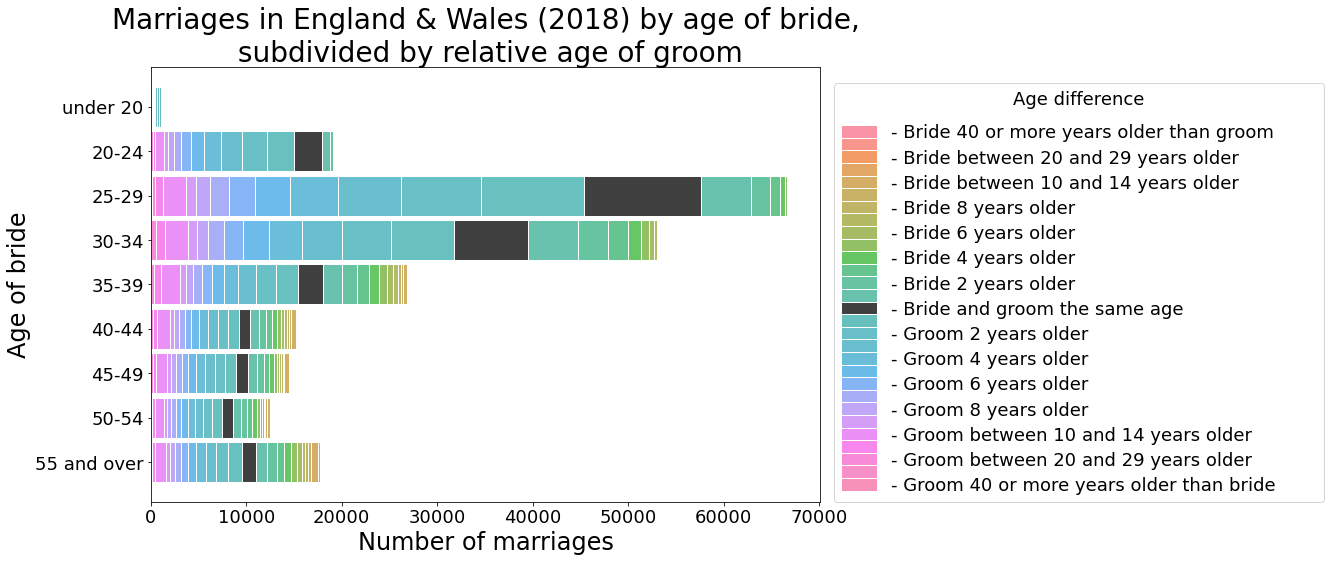

In [817]:
def move_legend(ax, new_loc, new_title, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = new_title
    ax.legend(handles, labels, loc=new_loc, title=title, labelspacing=-0.3, **kws)

# hack the central colour in the chosen palette, to highlight the central category
hist_palette = [sns.color_palette("husl", 29)[a] if a != 14 else (0, 0, 0) for a in range(29)]
# plot a stacked histogram of the bride age by age diff
ax = sns.histplot(data, y="bride_age_label", weights="frequency", hue="age_dif_label",
                  multiple="stack", edgecolor="white", shrink=0.9, linewidth=1, palette=hist_palette)

ax.set_title("Marriages in England & Wales (2018) by age of bride,\n subdivided by relative age of groom", 
             fontsize=28)
#plt.xticks(rotation=0);
plt.xlabel("Number of marriages", fontsize=24)
plt.ylabel("Age of bride", fontsize=24)
# put the legend to the right of the chart
move_legend(ax, (1.02, 0), "Age difference\n")

Now functionise the construction of this chart, so we can repeat it for all years where nomis has data.

In [688]:
def get_age_dif_dataset(year):
    q_json = "https://www.nomisweb.co.uk/api/v01/dataset/NM_164_1.data.json?date=" + str(year) + "&age_difference=0...30&ceremony_type=0&approved_premises=0&status_of_groom=0&status_of_bride=0&age_of_groom=0&age_of_bride=0...10&measures=20100&select=date_name,age_difference_name,ceremony_type_name,approved_premises_name,status_of_groom_name,status_of_bride_name,age_of_groom_name,age_of_bride_name,measures_name,obs_value,obs_status_name"
    response = requests.get(q_json)
    
    if response.status_code == 200:
        j_obs = []

        for obs in json.loads(response.text)["obs"]:
            j_obs.append([obs["age_difference"]["description"], 
                          obs["age_of_bride"]["description"], 
                          obs["obs_value"]["value"]])
    
        return pd.DataFrame(j_obs, columns=["age_difference", "age_of_bride", "frequency"])
        
    else:
        print("Data query failed: error " + response.status_code)
        
        return None
        

def draw_age_dif_histo(df, year):
    # drop categories we don't want to chart at all (totals and unknowns)
    df = df.drop(df[df.age_difference == "Total"].index)
    df = df.drop(df[df.age_difference == "Unknown age difference (ages not stated)"].index)
    df = df.drop(df[df.age_of_bride == "Total"].index)
    df = df.drop(df[df.age_of_bride == "Bride's age not stated"].index)
    
    # arrange for some age dif categories to have unique names made entirely of spaces, 
    # so their colours will show up in the legend, but without any label text, to reduce business
    df["age_dif_label"] = [" " * (40 + age_dif_lookups[a]) if a not in legend_entries 
                           else "- " + a for a in df.age_difference]
    # make shortened labels for bride age, to reduce repitition and save some space
    df["bride_age_label"] = [a.replace("Bride aged ", "") for a in df.age_of_bride]
    
    # hack the central colour in the chosen palette, to highlight the central category
    hist_palette = [sns.color_palette("husl", 29)[a] if a != 14 else (0, 0, 0) for a in range(29)]
    # plot a stacked histogram of the bride age by age diff
    ax = sns.histplot(df, y="bride_age_label", weights="frequency", hue="age_dif_label",
                      multiple="stack", edgecolor="white", shrink=0.9, linewidth=1, palette=hist_palette)

    chart_title = "Marriages in England & Wales ({}) by age of bride,\n".format(year)
    chart_title += "subdivided by relative age of groom"
    ax.set_title(chart_title, fontsize=28)
    ax.set_xlim(0, 80000)
    plt.xlabel("Number of marriages", fontsize=24)
    plt.ylabel("Age of bride", fontsize=24)
    # put the legend to the right of the chart
    move_legend(ax, (1.02, 0), "Age difference\n")
    
    return df

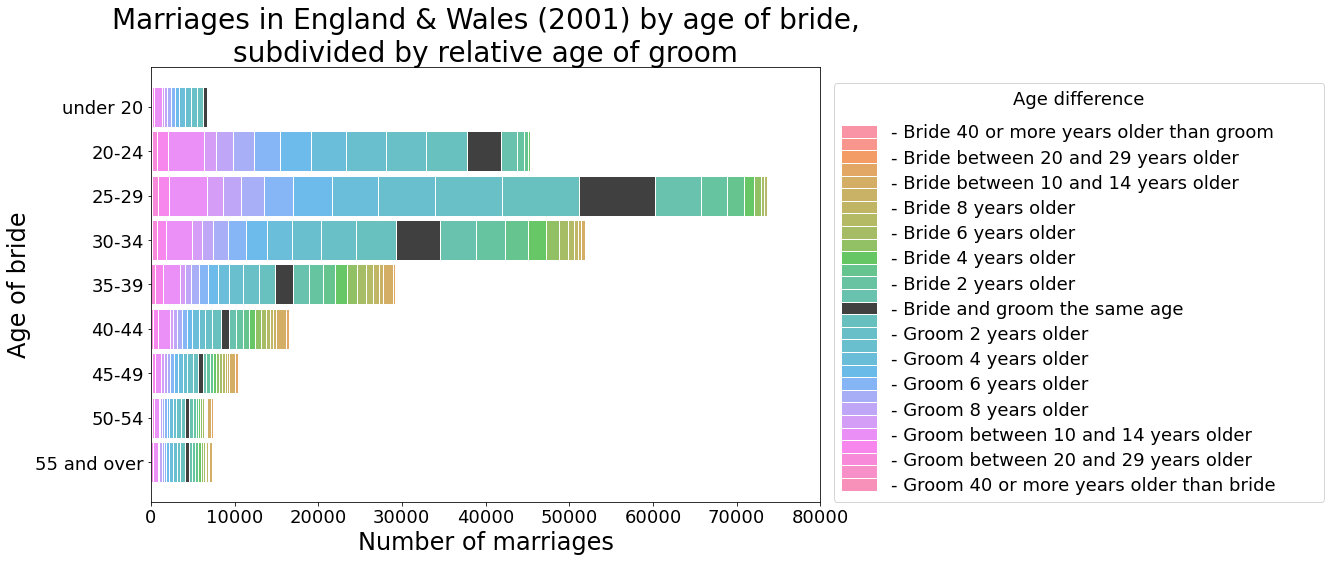

In [709]:
y = 2001
df_y = get_age_dif_dataset(y)
draw_age_dif_histo(df_y, y);

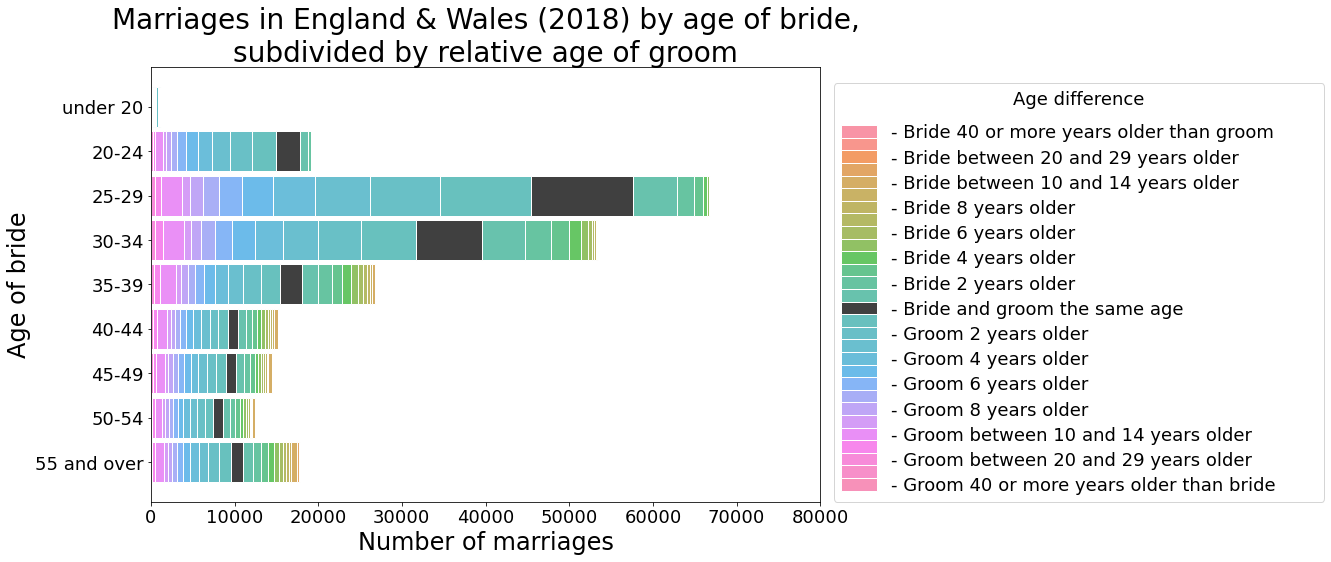

In [708]:
y = 2018
df_y = get_age_dif_dataset(y)
draw_age_dif_histo(df_y, y);

Make a long thin version of data, for use with heatmapping / surface plotting routines.

In [213]:
df_dist = df.copy()

df_dist["age_diff"] = [age_dif_lookups[a] for a in df_dist.age_difference]
df_dist["wife_age"] = [bride_age_lookups[a] for a in df_dist.age_of_bride]
df_dist["freq_div1"] = [age_dif_bands_w[a] for a in df_dist.age_difference]
df_dist["freq_div2"] = [bride_age_bands_w[a] for a in df_dist.age_of_bride]
df_dist["freq_div"] = df_dist["freq_div1"] * df_dist["freq_div2"]
df_dist["single_age_freq"] = df_dist.frequency / df_dist["freq_div"]
df_dist["husband_age"] = df_dist.wife_age + df_dist.age_diff
df_dist = df_dist.drop(columns=["age_difference", "age_of_bride", "freq_div", "freq_div1", "freq_div2"])

#df_dist = df_dist.set_index(["husband_age", "wife_age"])
#df_dist = df_dist.drop(index=np.nan, level=0).drop(index=np.nan, level=1)
df_dist.head(30)

,frequency,age_diff,wife_age,single_age_freq,husband_age
0,227870,NaN,NaN,227870.00,NaN
1,1186,NaN,18.0,296.50,NaN
2,19193,NaN,22.0,3838.60,NaN
3,66806,NaN,27.0,13361.20,NaN
4,53381,NaN,32.0,10676.20,NaN
5,26858,NaN,37.0,5371.60,NaN
6,15304,NaN,42.0,3060.80,NaN
7,14642,NaN,47.0,2928.40,NaN
8,12596,NaN,52.0,2519.20,NaN
9,17873,NaN,60.0,1787.30,NaN


In [214]:
df_dist2 = df_dist.dropna()
df_dist2

,frequency,age_diff,wife_age,single_age_freq,husband_age
12,0,-40.0,18.0,0.00,-22.0
13,0,-40.0,22.0,0.00,-18.0
14,0,-40.0,27.0,0.00,-13.0
15,0,-40.0,32.0,0.00,-8.0
16,0,-40.0,37.0,0.00,-3.0
...,...,...,...,...,...
324,5,40.0,37.0,0.10,77.0
325,4,40.0,42.0,0.08,82.0
326,1,40.0,47.0,0.02,87.0
327,0,40.0,52.0,0.00,92.0


Apply interpolation to break down and smooth out the heavily-banded data.

In [885]:
data_x_y = list(zip(df_dist2.wife_age, df_dist2.husband_age))
data_z = df_dist2.single_age_freq
data_x_y = data_x_y + [(15, 15), (15, 100), (100, 15), (100, 100)]
data_z = data_z.append(pd.Series([0, 0, 0, 0]))

grid_x, grid_y = np.mgrid[16:60, 16:60]
znew = interpolate.griddata(data_x_y, data_z, (grid_x, grid_y), method='cubic', fill_value=0)

znew

array([[ 3.24501819e+00, -3.60641479e+00, -2.71183523e+01, ...,
        -1.40242912e+01, -1.35496040e+01, -1.30505870e+01],
       [ 1.01081788e+00,  1.42756362e+01,  3.52854183e+01, ...,
        -4.02171621e+00, -3.64147571e+00, -3.25934653e+00],
       [ 7.50000000e-01,  9.25000000e+00,  2.97500000e+01, ...,
         1.42104270e-02,  2.50000000e-02,  5.10806692e-02],
       ...,
       [-2.43326293e-01, -1.70048350e-01, -2.79456913e-01, ...,
         1.17675743e+02,  1.15672230e+02,  1.22035188e+02],
       [-3.54888963e-01, -2.59035428e-01, -1.21214483e-01, ...,
         1.07113256e+02,  1.10526009e+02,  1.22564782e+02],
       [-5.24908011e-01, -4.09421582e-01, -2.50488070e-01, ...,
         9.51284516e+01,  1.04407469e+02,  1.22072491e+02]])

Try a heatmap of the interpolated data

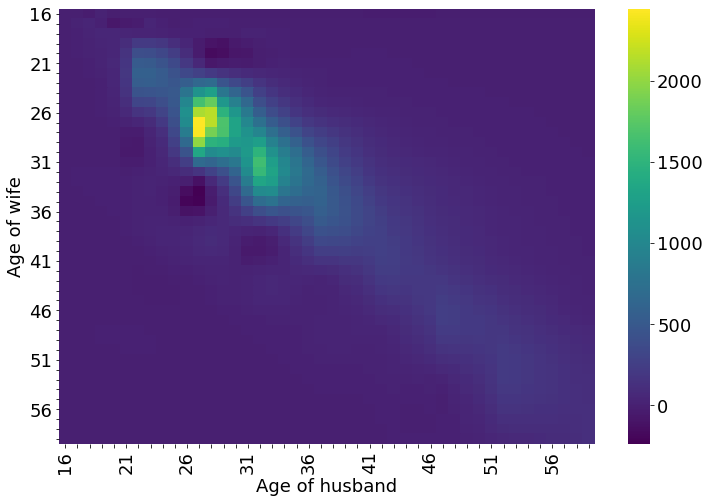

In [775]:
hm = sns.heatmap(znew, cmap=plt.cm.viridis, cbar=True,
                 xticklabels=range(16, 60), yticklabels=range(16, 60))

for i, l in enumerate(hm.get_xticklabels()):
    l.set_visible(i % 5 == 0)
    
for i, l in enumerate(hm.get_yticklabels()):
    l.set_visible(i % 5 == 0)

plt.xlabel("Age of husband")
plt.ylabel("Age of wife")
plt.show()

And try a surface plot

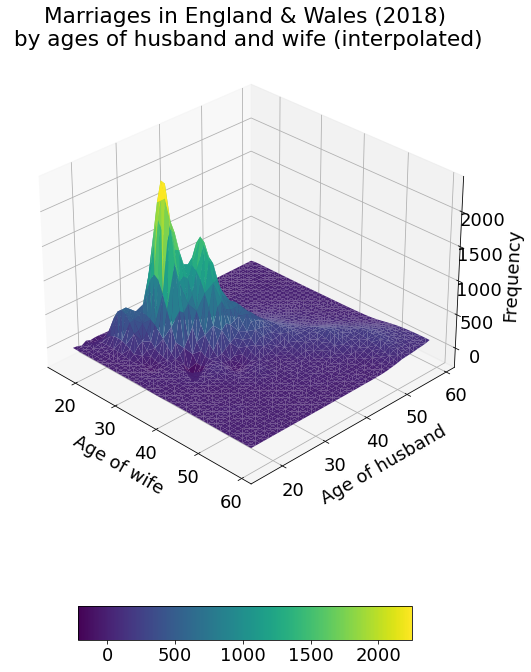

In [805]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(grid_x.flatten(), grid_y.flatten(), znew.flatten(), 
                       cmap=plt.cm.viridis, linewidth=0.2, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=10, orientation='horizontal')
ax.set_xlabel("\nAge of wife")
ax.set_ylabel("\nAge of husband")
ax.set_zlabel("\nFrequency")
ax.view_init(30, -45)
ax.set_title("Marriages in England & Wales (2018)\n by ages of husband and wife (interpolated)")
plt.show()

### 2. Examine ONS's data on divorces

https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdivorce%2fdatasets%2fdivorcesinenglandandwales%2f2020/divorcesworkbook2020final31012022144352.xlsx

Inspection of the spreadsheet suggests male and female data are presented as independent; without being able to isolate age diff at divorce, I think it can't change the difference in ages of extant married couples. So just try to pick a simple assumption for divorce rate.

In [836]:
divorces = pd.read_csv("data/divorces.csv")
divorces["type"] = ["historic" for a in divorces.index]
divorces

,Year,Divorces per 1000 marriages
0,2020,8.4
1,2019,8.9
2,2018,7.5
3,2017,8.4
4,2016,8.9
...,...,...
66,1954,2.5
67,1953,2.7
68,1952,3.0
69,1951,2.6


In [869]:
f = interpolate.interp1d(x=divorces["Year"], y=divorces["Divorces per 1000 marriages"], fill_value="extrapolate")
extrapolated_y = [[a, f(a).flatten()[0], "extrapolated"] for a in range(2021, 2080)]
extra_y = pd.DataFrame(extrapolated_y, columns=["Year", "Divorces per 1000 marriages", "type"])
divorces2 = pd.concat([divorces, extra_y]).set_index("Year").sort_index()

,Year,Divorces per 1000 marriages,type
0,2021,7.9,extrapolated
1,2022,7.4,extrapolated
2,2023,6.9,extrapolated
3,2024,6.4,extrapolated
4,2025,5.9,extrapolated
5,2026,5.4,extrapolated
6,2027,4.9,extrapolated
7,2028,4.4,extrapolated
8,2029,3.9,extrapolated
9,2030,3.4,extrapolated


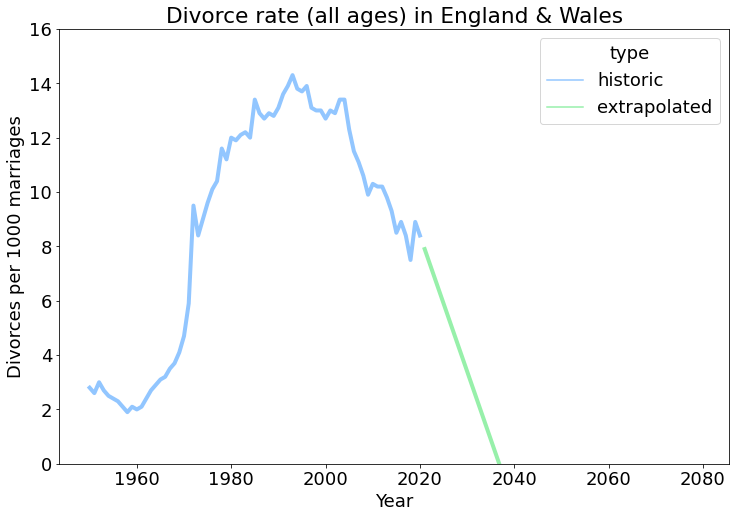

In [880]:
ax = sns.lineplot(x=divorces2.index, y=divorces2["Divorces per 1000 marriages"], 
                  hue=divorces2.type, linewidth=4)
ax.set_ylim(0, 16)
ax.set_title("Divorce rate (all ages) in England & Wales");

The behaviour of overall divorce rates is pretty odd. Given how widely it fluctuates in just a few decades, how can we predict where it will go in future? Linear extrapolation doesn't look at all sensible, as it soon reaches 0%. One might as well guess that it stays at the current rate of 0.8%p.a. which is at least roughly the mean for the period covered by the data.

### Examine ONS mortality projections

From the mortality projections in https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2flifeexpectancies%2fdatasets%2fmortalityratesqxprincipalprojectionenglandandwales%2f2020based/ewppp20qx.xlsx, saved 'males cohort qx' and 'females cohort qx' sheets as csv files.<br>
These are numbers of deaths per 100,000 people per year, at each age and year form 1981 to 2070.

In [992]:
m_qx = pd.read_csv("data/male_qx.csv").set_index("age")
m_qx = m_qx.apply(pd.to_numeric, errors='coerce')
f_qx = pd.read_csv("data/female_qx.csv").set_index("age")
f_qx = f_qx.apply(pd.to_numeric, errors='coerce')
m_qx

,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,...,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070
age,,,,,,,,,,,,,,,,,,,,,
0,1259.45,1217.86,1130.81,1059.73,1044.46,1102.18,1047.13,1027.39,957.29,891.70,...,210.11,207.60,205.25,202.71,200.21,197.79,195.49,193.31,190.91,188.50
1,89.14,72.38,81.22,78.03,67.55,69.79,73.62,70.39,68.93,66.12,...,19.12,18.92,18.68,18.36,18.29,18.14,17.92,17.74,17.55,16.96
2,47.91,44.03,52.04,44.91,46.43,43.54,45.93,43.99,38.06,33.80,...,8.70,8.64,8.56,8.47,8.29,8.19,8.17,7.98,7.79,7.77
3,41.95,39.51,37.77,30.46,33.97,35.08,33.19,33.24,25.94,27.50,...,4.47,4.48,4.40,4.32,4.31,4.22,4.13,4.12,4.02,3.93
4,29.73,26.19,28.66,24.22,26.13,26.13,21.98,25.24,22.20,21.18,...,3.86,3.79,3.79,3.79,3.70,3.53,3.44,3.35,3.26,3.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,19510.26,19363.97,19218.95,19075.07,18931.84,18789.57,18648.15,18507.70,18368.68,18230.61,...,10519.03,10437.22,10356.05,10275.51,10195.59,10116.30,10037.62,9959.56,9882.10,9805.24
97,21762.85,21613.94,21466.83,21319.49,21172.51,21026.77,20882.39,20738.65,20595.77,20454.00,...,12359.46,12271.37,12183.91,12097.07,12010.85,11925.24,11840.24,11755.85,11672.06,11588.87
98,24243.07,24092.58,23942.59,23793.10,23644.46,23497.63,23350.59,23204.83,23060.28,22915.49,...,14498.95,14405.01,14311.69,14218.97,14126.85,14035.33,13944.40,13854.06,13764.30,13675.13


So we can project the interpolated figures on number of marriages by ages of husband and wife, decrementing the number of extant marriage by 0.8% per year to account for divorce, and by the male mortality rate for the appropriate age and year, and by the female mortality rate for the appropriate age and year.

In [994]:
mar_2018_cohort = pd.DataFrame({"husband_age": grid_x.flatten(),
                                "wife_age": grid_y.flatten(),
                                "frequency": [max(f, 0) for f in znew.flatten()]})
mar_2018_cohort

,husband_age,wife_age,frequency
0,16,16,3.245018
1,16,17,0.000000
2,16,18,0.000000
3,16,19,14.515377
4,16,20,0.000000
...,...,...,...
1931,59,55,79.493348
1932,59,56,90.437594
1933,59,57,95.128452
1934,59,58,104.407469


### 4. Carry out the projection of a single marriage cohort

In [995]:
divorce_rate_assump = 0.008
cohort_proj = {2018: mar_2018_cohort}

for y in range(2019, 2060):
    next_y = cohort_proj[y - 1].copy()
    
    # everyone gets 1 year older
    next_y.husband_age = [a + 1 for a in next_y.husband_age]
    next_y.wife_age = [a + 1 for a in next_y.wife_age]
    
    # apply divorce rate
    next_y.frequency = [f * (1 - divorce_rate_assump) for f in next_y.frequency]
    
    for i in next_y.index:
        # apply mQx
        h = min(100, next_y.loc[i, "husband_age"])
        next_y.loc[i, "frequency"] = next_y.loc[i, "frequency"] * (1 - m_qx.loc[h, str(y)] / 100000)
        # apply fQx
        w = min(100, next_y.loc[i, "wife_age"])
        next_y.loc[i, "frequency"] = next_y.loc[i, "frequency"] * (1 - f_qx.loc[w, str(y)] / 100000)
        
    # save out the result
    cohort_proj[y] = next_y.copy()

,husband_age,wife_age,frequency
0,17,17,3.218206
1,17,18,0.000000
2,17,19,0.000000
3,17,20,14.395018
4,17,21,0.000000
...,...,...,...
1931,60,56,78.419289
1932,60,57,89.201480
1933,60,58,93.811695
1934,60,59,102.943175


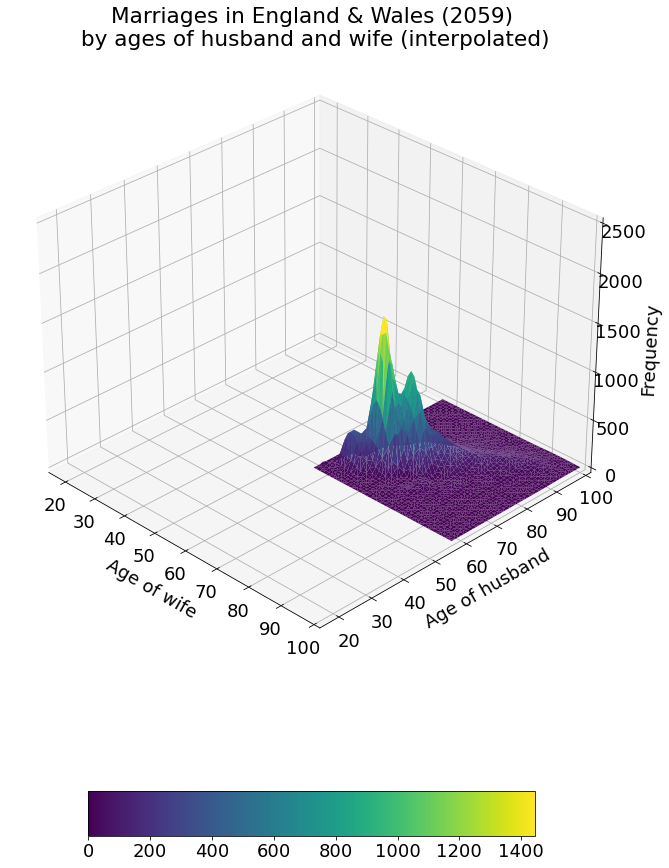

In [1018]:
def surface_map(year, angle):
    fig = plt.figure(figsize=(16, 16))
    ax = fig.gca(projection='3d')
    surf = ax.plot_trisurf(cohort_proj[year].husband_age, 
                           cohort_proj[year].wife_age, 
                           cohort_proj[year].frequency, 
                           cmap=plt.cm.viridis, linewidth=0.2, antialiased=True)
    fig.colorbar(surf, shrink=0.5, aspect=10, orientation='horizontal')
    ax.set_xlabel("\nAge of wife")
    ax.set_ylabel("\nAge of husband")
    ax.set_zlabel("\nFrequency")
    ax.view_init(30, angle)
    ax.set_xlim(16, 100)
    ax.set_ylim(16, 100)
    ax.set_zlim(0, 2500)
    ax.set_title("Marriages in England & Wales ({})\n".format(year) + 
                 " by ages of husband and wife (interpolated)")
    plt.show()
    
surface_map(2059, -45)

Save down some animations of the surface plot to get a better feel for its shape

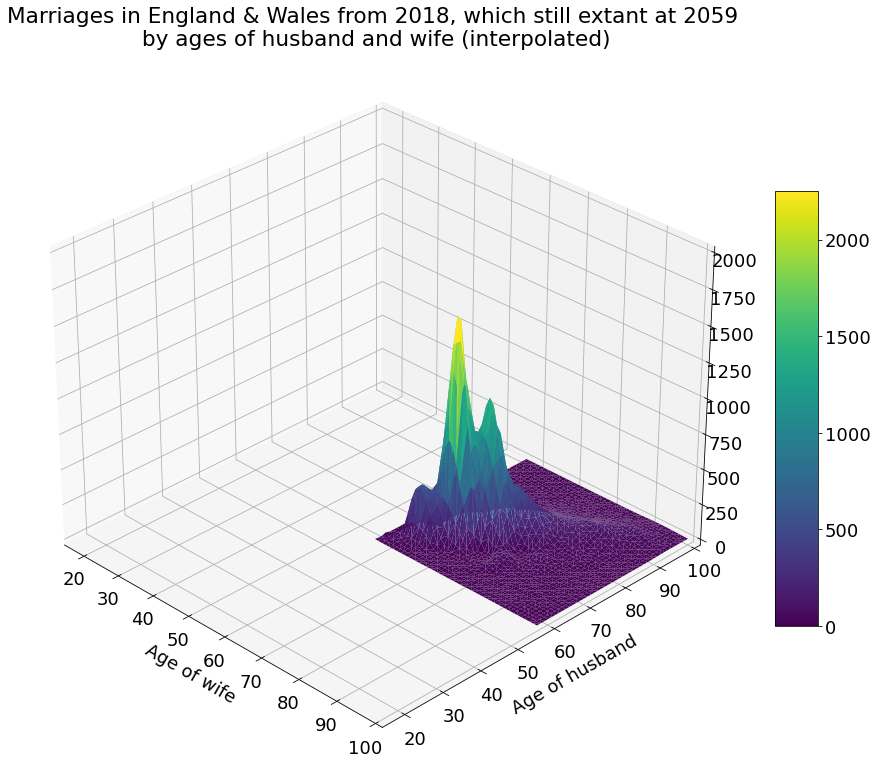

In [1041]:
fig = plt.figure(figsize=(16, 16))
ax = fig.gca(projection='3d')
ax.set_xlabel("\nAge of wife")
ax.set_ylabel("\nAge of husband")
ax.view_init(30, -45)
ax.set_xlim(16, 100)
ax.set_ylim(16, 100)
ax.set_zlim(0, 2000)

def init():
    surf = ax.plot_trisurf(cohort_proj[2018].husband_age, 
                           cohort_proj[2018].wife_age, 
                           cohort_proj[2018].frequency, 
                           cmap=plt.cm.viridis, linewidth=0.2, antialiased=True)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    ax.set_title("Marriages in England & Wales ({})\n".format(2018) + 
                 " by ages of husband and wife (interpolated)")
    
def animate(year):
    ax.clear()
    ax.set_xlabel("\nAge of wife")
    ax.set_ylabel("\nAge of husband")
    ax.view_init(30, -45)
    ax.set_xlim(16, 100)
    ax.set_ylim(16, 100)
    ax.set_zlim(0, 2000)
    surf = ax.plot_trisurf(cohort_proj[year].husband_age, 
                           cohort_proj[year].wife_age, 
                           cohort_proj[year].frequency, 
                           cmap=plt.cm.viridis, linewidth=0.2, antialiased=True)    
    #fig.colorbar(surf, shrink=0.5, aspect=10, orientation='horizontal')
    ax.set_title("Marriages in England & Wales from 2018, which still extant at {}\n".format(year) + 
                 " by ages of husband and wife (interpolated)")

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=range(2019, 2060), repeat=True)

savefile = "surface_anim_years.gif"
pillowwriter = animation.PillowWriter(fps=3)
anim.save(savefile, writer=pillowwriter)

plt.show()

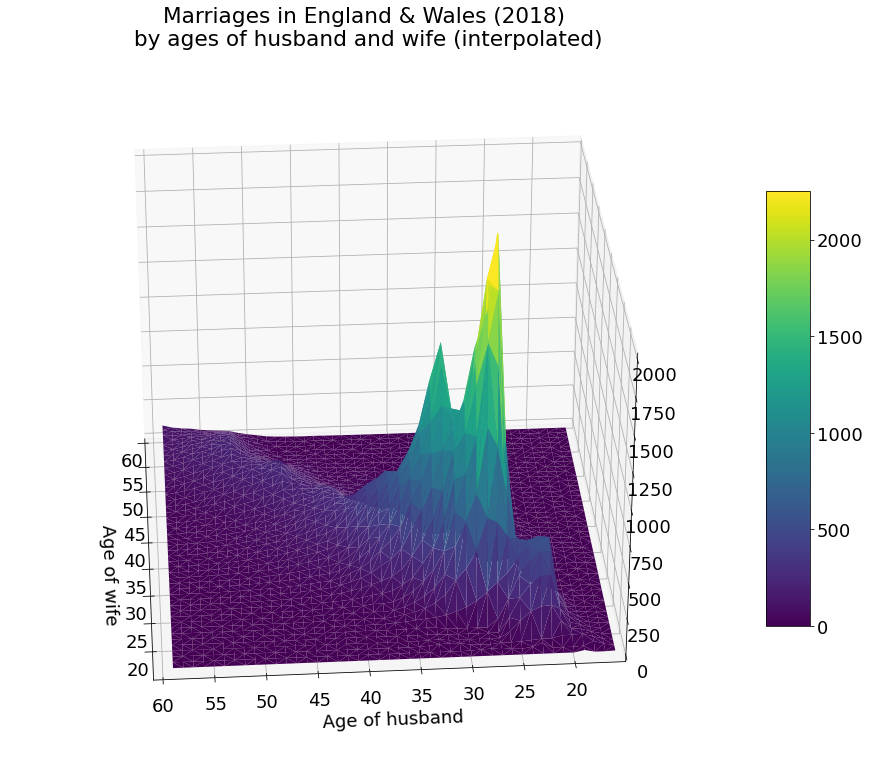

In [1039]:
fig = plt.figure(figsize=(16, 16))
ax = fig.gca(projection='3d')
ax.set_xlabel("\nAge of wife")
ax.set_ylabel("\nAge of husband")
ax.view_init(30, -45)
ax.set_xlim(16, 60)
ax.set_ylim(16, 60)
ax.set_zlim(0, 2000)

def init():
    surf = ax.plot_trisurf(cohort_proj[2018].husband_age, 
                           cohort_proj[2018].wife_age, 
                           cohort_proj[2018].frequency, 
                           cmap=plt.cm.viridis, linewidth=0.2, antialiased=True)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    ax.set_title("Marriages in England & Wales ({})\n".format(2018) + 
                 " by ages of husband and wife (interpolated)")
    
def animate(angle):
    ax.clear()
    ax.set_xlabel("\nAge of wife")
    ax.set_ylabel("\nAge of husband")
    ax.view_init(30, angle)
    ax.set_xlim(16, 60)
    ax.set_ylim(16, 60)
    ax.set_zlim(0, 2000)
    surf = ax.plot_trisurf(cohort_proj[2018].husband_age, 
                           cohort_proj[2018].wife_age, 
                           cohort_proj[2018].frequency, 
                           cmap=plt.cm.viridis, linewidth=0.2, antialiased=True)    
    #fig.colorbar(surf, shrink=0.5, aspect=10, orientation='horizontal')
    ax.set_title("Marriages in England & Wales ({})\n".format(2018) + 
                 " by ages of husband and wife (interpolated)")

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=range(-179, 180, 5), repeat=True)

savefile = "surface_anim_angle.gif"
pillowwriter = animation.PillowWriter(fps=6)
anim.save(savefile, writer=pillowwriter)

plt.show()